In [0]:
import keras
keras.__version__

'2.2.5'

###数据导入和处理


In [0]:
from numpy import genfromtxt
import numpy as np
my_data1 = genfromtxt('EMG_1ac10sec_MAT1-12.csv', delimiter=',')
my_data2 = genfromtxt('EMG_1ac10sec_MAT3-12.csv', delimiter=',')
my_data3 = genfromtxt('EMG_1ac10sec_MAT4-12.csv', delimiter=',')
my_data4 = genfromtxt('EMG_1ac10sec_MAO4-12.csv', delimiter=',')
my_data5 = genfromtxt('EMG_1ac10sec_MAO5-12.csv', delimiter=',')
my_data = np.concatenate((my_data1,my_data2,my_data3,my_data4,my_data5),axis=1)
# my_data=my_data1


#####每stepsize个连续的原始数据组成一个时间子序列，允许每两个label边界处两个label划分到一个子序列的情况(该方法的好处是：将多个数据集concatenate到一起后更容易做切片操作),然后将每个子序列(子序列长度为stepsize)作为新的example输入到 LSTM 中。

In [0]:
stepsize=30

data = my_data[1:10]
mydata = data.T
len_d=mydata.shape[0]     #length of data
num_s=int(len_d/stepsize) #number of subsequence
data=np.ndarray((num_s,stepsize,9))
for i in range(num_s):
  for j in range(stepsize):
    for k in range(9):
      data[i,j,k]=mydata[stepsize*i+j,k]  #slice every stepsize original examples

Data Splitting

In [0]:
#分割数据时需要考虑是否 shuffle 数据, here we shuffle the data
np.random.seed(0)
np.random.shuffle(data)
features=data[:,:,0:8]
label=data[:,:,8:9]-1
label=np.reshape(label,(label.shape[0]*label.shape[1],1))
print("original shape: {0}".format(features.shape))

length =features.shape[0]
train_x = features[0:int(length*0.7), :,:]
train_y = label[0:int(length*0.7)*stepsize, :]
dev_x = features[int(length*0.7):int(length*0.9),:,:]
dev_y = label[int(length*0.7)*stepsize:int(length*0.9)*stepsize, :]
test_x=features[int(length*0.9):,:,:]
test_y=label[int(length*0.9)*stepsize:,:]
print("splitted shape:{0}" .format(dev_y.shape))

original shape: (7139, 27, 8)
splitted shape:(38556, 1)


label的格式要和model要求的格式吻合，但是onehot之后的是二维数据，需要用reshape扩维;
Onehot的使用方法：使用sklearn库的LabelBinarizer方法进行 fit_transform,前提是数据本身得是 2 维的，如果维数不合适可在fit_transform之后使用numpy.reshape方法进行维数变换

Label Binarizer

In [0]:
from sklearn.preprocessing import LabelBinarizer
label_encoder=LabelBinarizer()
y_train=label_encoder.fit_transform(train_y)
y_val=label_encoder.fit_transform(dev_y)
y_test=label_encoder.fit_transform(test_y)
y_train=np.reshape(y_train,(int(y_train.shape[0]/stepsize),stepsize,y_train.shape[1]))
y_val=np.reshape(y_val,(int(y_val.shape[0]/stepsize),stepsize,y_val.shape[1]))
y_test=np.reshape(y_test,(int(y_test.shape[0]/stepsize),stepsize,y_test.shape[1]))
print("onehot之后的shape:{0}".format(y_test.shape))

onehot之后的shape:(714, 27, 12)


## Building network

For this reason we will use larger layers. Let's go with 64 units:

In [0]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
model = models.Sequential()
model.add(layers.LSTM(64,input_shape=(stepsize,8),activation='relu',return_sequences=True,dropout=0))
model.add(layers.LSTM(64, activation='relu',return_sequences=True))
model.add(layers.LSTM(32, activation='relu',return_sequences=True,dropout=0))
model.add(layers.LSTM(16, activation='relu',return_sequences=True,dropout=0))
model.add(layers.Dense(12, activation='softmax'))
epoch = 100
learning_rate = 0.001
decay_rate = learning_rate / epoch
momentum = 0.8
adam = optimizers.Adam(lr=learning_rate, decay=decay_rate)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Set checkpoints to save the best model

In [0]:
from keras.callbacks import ModelCheckpoint
import os
import argparse
# ap = argparse.ArgumentParser()
# ap.add_argument("-w","--weights",required=True, help="path to weights directory")
# args = vars(ap.parse_args())
fname = "weights.best.hdf5"
checkpoint = ModelCheckpoint(fname,monitor="val_acc",mode="max", save_best_only=True,verbose=1)
callbacks = [checkpoint]

## Validating our approach


Now let's train our network using grid search:

In [0]:
history = model.fit(train_x, y_train, epochs=epoch, 
                    batch_size=500, validation_data=(dev_x, y_val),callbacks=callbacks)

Train on 4997 samples, validate on 1428 samples
Epoch 1/100
4997/4997 [==============================] - 21s 4ms/step - loss: 2.2953 - acc: 0.1517 - val_loss: 2.1197 - val_acc: 0.1830

Epoch 00001: val_acc improved from -inf to 0.18295, saving model to weights.best.hdf5
Epoch 2/100
4997/4997 [==============================] - 14s 3ms/step - loss: 1.9340 - acc: 0.2352 - val_loss: 1.7404 - val_acc: 0.3244

Epoch 00002: val_acc improved from 0.18295 to 0.32444, saving model to weights.best.hdf5
Epoch 3/100
4997/4997 [==============================] - 14s 3ms/step - loss: 1.5439 - acc: 0.3748 - val_loss: 1.5178 - val_acc: 0.3513

Epoch 00003: val_acc improved from 0.32444 to 0.35128, saving model to weights.best.hdf5
Epoch 4/100
4997/4997 [==============================] - 14s 3ms/step - loss: 1.3000 - acc: 0.4696 - val_loss: 1.2559 - val_acc: 0.4821

Epoch 00004: val_acc improved from 0.35128 to 0.48208, saving model to weights.best.hdf5
Epoch 5/100
4997/4997 [============================

Let's display its loss and accuracy curves:

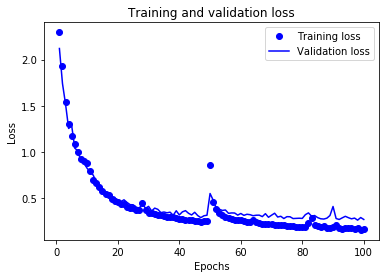

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

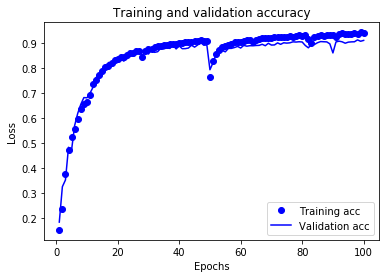

In [0]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## TEST

In [0]:
y_test.shape

(19278, 12)

In [0]:
#test_x=np.reshape(test_x,(test_x.shape[0],1,test_x.shape[1]))
#predictions = model.predict(test_x)
...
# evaluate the keras model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
model.load_weights('weights.best.hdf5')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
_, accuracy = model.evaluate(test_x, y_test)
print('Stepsize: %d \nAccuracy: %.2f' % (stepsize,accuracy*100))


ValueError: ignored

In [0]:
y_test = np.reshape(y_test,(y_test.shape[0]*y_test.shape[1],y_test.shape[2]))

In [0]:
y_pred = model.predict(test_x)
print(y_test.shape)
y_pred = np.reshape(y_pred,(y_pred.shape[0]*y_pred.shape[1],y_pred.shape[2]))

# accuracy = accuracy_score(y_test,y_pred.round())
matrix = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
# print('Accuracy: %.2f' % (accuracy*100))
print('Confusion Matrix:\n%s'%(matrix))